In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import periodogram, welch
from scipy.stats import ttest_rel,ttest_1samp,ttest_ind, sem

%matplotlib notebook

In this assignment we will apply descriptive statistics and statistical inference methods to power spectra of our EEG dataset, to review concepts and methods of Assignments 1 and 2. We will focus on the difference between parametric and nonparametric statistics. 

We start by loading the EEG data once again following Exercise 1 from last week (Assignment 3), but this time we do not transform the data using 10\*log10. 


In [2]:
data = loadmat("C:\\Users\\bnola\\Documents\\Data Analysis\\eeg.mat")

hd,hdh=data['hd'],data['hdh']
rec,rech=data['rec'],data['rech'][0]

rech = rech[:-1] #remove last point in rech, this is to avoid problems of matching array sizes further down

fs = 100 # sampling frequency of EEG
fs_hyp = 1.0/30.0 # sampling frequency of hypnogram

In [3]:
eeg=rec[1]

We want to chop our signal in pieces the size of the sampling interval of the hypnogram, and then compute the power spectra of these pieces separately and save them in an array. This will give us an estimate of power at each frequency (power spectrum) for each of the windows that define the hypnogram ratings. This will be very useful because then we will get power estimates sampled at the same time intervals as the hypnogram and we will be able to pass directly indices detected from the hypnogram ratings to the power estimation array.

In [4]:
n_window = 30*fs #the number of sample points in each 30s window used for the hypnogram, must be an integer

# take the original  signal and split it in pieces of length n_window, accumulate them in eegS
eegS =  []
for i in range(0,len(rec[1,:]),n_window):
    signal = rec[1,i:i+n_window] #the i-th piece of length n_window in rec[1,:]
    f,p = welch(signal-np.mean(signal), fs=fs) # power spectrum of the signal with the mean taken to remove baseline differences
    eegS.append(p)

# Convert to array for later convenience
eegS = np.array(eegS)
eegS.shape

(2830, 129)

## Exercise 1

This exercise should help you get a first intuition on the difference between mean and std, median and inter-quartile range. The first are parametric statistics, meaning they assume you have an underlying normal distribution from which you sampled your data. The latter don’t. 

a)	As an example, start by selecting the power of all your segments at 8 Hz. 

Hint: First find out which column contains the power for this frequency. You can use *np.where*


In [5]:
nf=np.where(f>8)[0] #list of indices for frequencies > 8 Hz
nf=nf[0] #take just the first element of nf, i.e. the index closest (and above) to 8 Hz

pow8 = eegS[:,nf] # extract the power at 8 Hz for each of the windows of 30s 

 b) We are going to look only at sleep stages, so divide your data in two groups: NREM12 and NREM34, based on the hypnogram in rech.

In [6]:
# Build booleans for each of the sleeping stages, now we use only NREM12 or the NREM34 conditions
in34 = (rech==3) | (rech==4) #NREM 34
in12 = (rech==1) | (rech==2) #NREM 12

#the booleans above correspond to rech, but because we built eegS at the exact 
#same sampling frequency as rech, we can directly use them to subset the data 
#from rech and pow8
pow_34=pow8[in34]
pow_12=pow8[in12]


c)	Now use *plt.hist* to plot the two distributions (for NREM12 and NREM34) of spectral power at 8 Hz.  Do they look Gaussian? Do you think they are different?

Hint: For better visualization,  use the same bins for both distributions with the option **bins=** of the *plt.hist* function. You can also make the histograms transparent by adding the option **alpha=**. Check how to use this in the help page for *plt.hist*

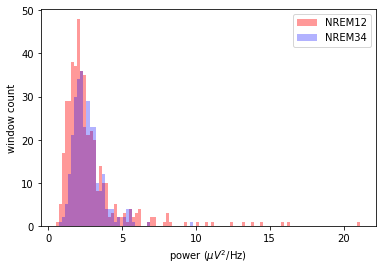

In [7]:
#we plot the first histogram, and keep the data in hst12 
hst12 = plt.hist(pow_12, bins=100, color="r", alpha=0.4, label="NREM12")
#we plot the 2nd histogram, now using the same bins as used in the 1st histogram (in hst12[1])
plt.hist(pow_34, bins=hst12[1], color='b', alpha=0.3, label='NREM34')
plt.xlabel(r"power ($\mu V^2$/Hz)")
plt.ylabel("window count")
plt.legend();

d)	On the same figure, plot the two distributions using *plt.hist* and the values for each of the statistics we are studying: mean, median, std and prctile just like in the figure blelow. If you were to rely on your parametric statistics, which of the two conditions, NREM12 or NREM34, would be characterized by higher spectral power at 8 Hz? What would be the conclusion if you used nonparametric statistics? Why this discrepancy? Which one do you trust?

Hint: Use *np.percentile* to plot the inter-quartile range as the distance between the Q25 and Q75


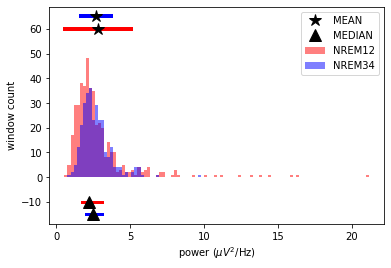

In [8]:
#First, same as above:
hst12 = plt.hist(pow_12, bins=100, color="r", alpha=0.5, label="NREM12")
#we plot the 2nd histogram, now using the same bins as used in the 1st histogram (in hst12[1])
plt.hist(pow_34, bins=hst12[1], color='b', alpha=0.5, label='NREM34')
plt.xlabel(r"power ($\mu V^2$/Hz)")
plt.ylabel("window count")
plt.legend();

# Now we compute descriptive statistics for NREM12
mn, sd, md = [np.mean(pow_12), np.std(pow_12), np.median(pow_12)] # mean, standard deviation, median
iqr=np.percentile(pow_12,[25, 75]) #the interquartile range is flanked by the 25% and 75% percentiles of the distribution
plt.plot([mn-sd,mn+sd],[60,60],'r',linewidth=4)
plt.plot(mn,60,'k*',markersize=12,markerfacecolor='k')
plt.plot(iqr,[-10,-10],'r',linewidth=3)
plt.plot(md,-10,'k^',markersize=12,markerfacecolor='k')

# Now the same thing for NREM34
mn, sd, md = [np.mean(pow_34), np.std(pow_34), np.median(pow_34)]
iqr=np.percentile(pow_34,[25, 75]) 
plt.plot([mn-sd, mn+sd],[65, 65],'b',linewidth=4)
plt.plot(mn,65,'k*',markersize=12,markerfacecolor='k',label="MEAN")
plt.plot(iqr,[-15, -15],'b',linewidth=3)
plt.plot(md,-15,'k^',markersize=12,markerfacecolor='k', label="MEDIAN")

plt.legend();

The figure shows that for these two distributions, if we were to compare their means we would conclude that if there is a difference, NREM12 has higher power at 8Hz than NREM34 (the mean of the NREM34 distribution is lower than that of the NREM12 distribution). Instead, if we were looking at the median (non-parametric statistics) our conclusion would be the opposite! (the median power at 8 Hz is lower for NREM12 than for NREM34). There is a discrepancy that is due to the fact that NREM12 distribution has outliers, a very few windows with very high 8 Hz power despite the fact that the large majority of windows in NREM12 have lower 8Hz power than most of the windows in NREM34 (the red histogram is clearly to the left of the blue but there are a few red points with power > 1000). In this condition (highly non-Gaussian distribution), parametric statistics are distorted by these outlier values and give wrong estimates of centrality of the distribution. We should be using non-parametric measures (median) because the distributions are clearly non-Gaussian.

e)	Repeat the exercise, but now transform the data using 10\*log10. Do you understand the use of 10\*log10 now? 

Hint: Which one looks more Gaussian?

If you now look at the parametric and nonparametric central estimates of the two distributions, do they agree qualitatively? Can you see the risks of using parametric statistics to describe non-normal data?

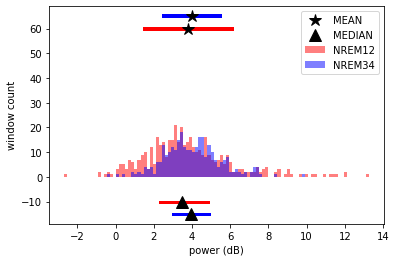

In [9]:
## We first transform our data with 10*np.log10
pow_12_g = 10*np.log10(pow_12) # convert pow_12 to dB
pow_34_g = 10*np.log10(pow_34) # convert pow_34 to dB

#First, same as above:
hst12 = plt.hist(pow_12_g, bins=100, color="r", alpha=0.5, label="NREM12")
#we plot the 2nd histogram, now using the same bins as used in the 1st histogram (in hst12[1])
plt.hist(pow_34_g, bins=hst12[1], color='b', alpha=0.5, label='NREM34')
plt.xlabel(r"power ($\mu V^2$/Hz)")
plt.ylabel("window count")
plt.legend();

# Now we compute descriptive statistics for NREM12
mn, sd, md = [np.mean(pow_12_g), np.std(pow_12_g), np.median(pow_12_g)] # mean, standard deviation, median
iqr=np.percentile(pow_12_g,[25, 75]) #the interquartile range is flanked by the 25% and 75% percentiles of the distribution
plt.plot([mn-sd,mn+sd],[60,60],'r',linewidth=4)
plt.plot(mn,60,'k*',markersize=12,markerfacecolor='k')
plt.plot(iqr,[-10,-10],'r',linewidth=3)
plt.plot(md,-10,'k^',markersize=12,markerfacecolor='k')

# Now the same thing for NREM34
mn, sd, md = [np.mean(pow_34_g), np.std(pow_34_g), np.median(pow_34_g)]
iqr=np.percentile(pow_34_g,[25, 75]) 
plt.plot([mn-sd, mn+sd],[65, 65],'b',linewidth=4)
plt.plot(mn,65,'k*',markersize=12,markerfacecolor='k',label="MEAN")
plt.plot(iqr,[-15, -15],'b',linewidth=3)
plt.plot(md,-15,'k^',markersize=12,markerfacecolor='k', label="MEDIAN")

plt.legend();

plt.xlabel("power (dB)")

plt.legend();



10 log10 is transforming the non-Gaussian distributions of power into Gaussian transformed distributions. Spectral power is known to have this property that logarithms make it Gaussian. Other quantities may need a different transformation. When we estimate centrality parameters from these Gaussian distributions, we obtain qualitatively consistent results whether we rely on parametric or non-parametric measures (mean or median). For both mean and median, NREM12 has lower log power at 8 Hz than NREM34. Everything is consistent! Parametric measures should only be used with Gaussian distributed data.

# Exercise 2

Are the two distributions really different? In this exercise we will implement the bootstrapping method introduced in the videos. To infer from our sampled data our confidence on the estimate of a measure of centrality (mean, median, etc.) we again have two options: parametric methods (a) if our data is Gaussian (and in this case we have the standard error of the mean, which is the standard deviation of the data divided by the square root of the number of samples), or nonparametric methods (b) in the general case (and then we use bootstrapping).

a) based on the Gaussian-transformed data (10\*log10), compute the standard error of the mean (s.e.m.) of each of the two distributions. Two s.e.m.’s define the 95% confidence interval, based on the Gaussian distribution. If any of the two means is more than 2 standard errors from the other mean, we can say that the two distributions have different means with a confidence of 95%, or p<0.05.


In [10]:
from scipy.stats import sem

print('Parametric')
mn12=np.mean(pow_12_g) # mean of log power for NREM12
sem12=sem(pow_12_g) # standard error of the mean for log power for NREM12
print(mn12, 'CI = [' , mn12 - 2*sem12,  mn12 + 2*sem12, ']' )
mn34=np.mean(pow_34_g) # mean of log power for NREM34
sem34=sem(pow_34_g) # standard error of the mean for log power for NREM34
print(mn34, 'CI = [' , mn34 - 2*sem34,  mn34 + 2*sem34, ']' )



Parametric
3.803512926392721 CI = [ 3.5834881873250177 4.023537665460425 ]
4.0018011372722935 CI = [ 3.8300622685553956 4.173540005989191 ]


b) We now want to estimate the 95% confidence interval non-parametrically using a bootstrapping method. To this end, we will generate fake data: 1,000 bootstrap samples obtained by repeatedly resampling with replacement from each of our two datasets (NREM12 and NREM34 at 8Hz). To accomplish this, we need to generate randomly a list of indices that resample from our data (take a look at *randint*). For each of the 1,000 fake datasets that we build this way, compute the centrality measure of our choice (mean, median, etc.) and save it in a list, so that we finally have 1,000 measures characterizing each of our 1,000 fake datasets. The standard deviation of each of these two lists gives me the nonparametric estimate of the s.e.m., and the 2.5 and 97.5 percentiles of each of the two lists gives me the 95% confidence interval computed nonparametrically. Are the two medians significantly different?

In [11]:
print('Non-Parametric')

n12=len(pow_12) #number of data points in NREM12
n34=len(pow_34) #number of data points in NREM34
boots12=[] # create empty arrays to store all the bootstrap samples
boots34=[]

for _ in range(0,100000): # run a loop through all the bootstrap samples
    ind12 = np.random.randint(0,n12,n12) # generate random indices with replacement from the possible n1 indices
    boots12.append(np.median(pow_12[ind12])) #save the statistic for this resample in the array for NREM12
    #
    ind34 = np.random.randint(0,n34,n34) # same thing for pow_34
    boots34.append(np.median(pow_34[ind34]))   

# now print the result of the confidence interval obtained from this bootstrap method
print( np.median(pow_12), 'CI=', np.percentile(boots12,[2.5, 97.5]) )
print( np.median(pow_34), 'CI=', np.percentile(boots34,[2.5, 97.5]) )


Non-Parametric
2.2347682365764077 CI= [2.14125839 2.3748678 ]
2.4695718812908174 CI= [2.29903688 2.62485782]


# Exercise 3

a) Plot the whole mean spectrum (for all frequencies) for NREM12 and NREM34 with 95% confidence intervals obtained from parametric statistics. Hint: you can use *plt.errorbar* to plot as in the figure below, or you can explore and use *plt.fill_between* for nicer plots (see b below)

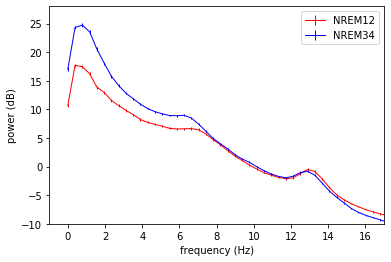

In [20]:
eegSdB = 10*np.log10(eegS) # transform power to dB, so we can use parametric methods
# now plot with errorbars the confidence interval around the mean, using parametric statistics (sem)
# for NREM12, remember that the boolean that selects the right windows is in12
plt.errorbar(x=f, y=np.mean(eegSdB[in12], axis=0), yerr=(2*sem(eegSdB[in12])) ,color='r',label="NREM12",linewidth=1) 
plt.errorbar(x=f, y=np.mean(eegSdB[in34], axis=0), yerr=(2*sem(eegSdB[in34])) ,color='b',label="NREM34",linewidth=1) 

plt.xlim(-1,17)
plt.ylim(-10,28)
plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('power (dB)');

b) Now use bootstrapping to determine 95% confidence interval non-parametrically using the original non-Gaussian data in eegS. In the following code, instead of filling in the code, please fill in the comments to explain what is happening in each step of the code.

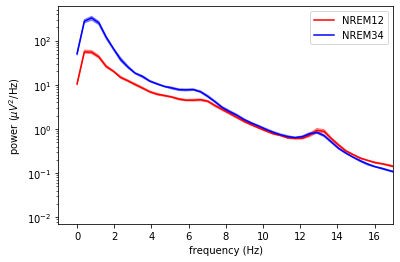

In [13]:
# we now use bootstrapping to determine 95% CI non-parametrically, using the original, non-Gaussian data in eegS

#first we ??? create empty arrays
sample12=[]
sample34=[]

# turn booleans in12 and in34 into index numbers for resampling with replacement
inx12 = np.where(in12)[0]
inx34 = np.where(in34)[0]

# ??? convert the booleans into a number based on the number of data points for NREM12 and NREM34
n12=len(inx12)
n34=len(inx34)

# ??? creating a loop for the bootstrap samples, for iteration 
for _ in range(1000):
    # ??? generates random indices for both NREM12 and NREM34
    resample12 = inx12[np.random.randint(0,n12,n12)]; 
    resample34 = inx34[np.random.randint(0,n34,n34)];
    
    # ??? saving the resampling into the EEG array
    sample12.append(np.median(eegS[resample12,:],0))
    sample34.append(np.median(eegS[resample34,:],0))

#make sure the resampled statistics are in a numpy array
sample12=np.array(sample12)
sample34=np.array(sample34)

# ??? get the confidence intervals for the bootstraps
pcrt_12 = np.array([[np.percentile(sample12[:,n],2.5), np.percentile(sample12[:,n],97.5)] for n in range(len(f))])
pcrt_34 = np.array([[np.percentile(sample34[:,n],2.5), np.percentile(sample34[:,n],97.5)] for n in range(len(f))])

# plot the median power spectrum
plt.plot(f,np.median(eegS[in12,:],0),label="NREM12",color='r')
# and plot ??? the confidence intervals
plt.fill_between(f,pcrt_12[:,0],pcrt_12[:,1], alpha=0.4, color='r')

# same for NREM34
plt.plot(f,np.median(eegS[in34,:],0),label="NREM34", color='b')
plt.fill_between(f,pcrt_34[:,0],pcrt_34[:,1], alpha=0.4,  color='b')

# ??? limits the x-axis to stop at 17 Hz (~beta waves and below (alpha, theta, delta)) 
plt.xlim(-1,17)
# ??? converts the y-axis to a logarithmic scale
plt.yscale('log')

# ??? creates a legend to label the lines (defaults to top right)
plt.legend()
# axis labels
plt.xlabel('frequency (Hz)')
plt.ylabel('power ($\mu V^2$/Hz)');

